### 이번 프로젝트 목표
---
앞선 이론에서 BERT 모델만 구성한 후 pretraining 없이 학습을 진행해 보며 BERT의 구조를 익혔습니다!  
이번엔 pretraining된 모델을 사용해서 실습을 진행해봅니다:)

---  

**공통**  

1. BERT pretrained model을 활용한 KorQuAD 모델을 정상적으로 학습 시키기  
    - KorQuAD 모델의 validation accuracy가 안정적으로 증가시킴

2. KorQuAD Inference 결과가 원래의 정답과 비교하여 유사하게 나오는 것을 확인하기
    - 평가셋에 대해 모델 추론 결과와 실제 정답의 유사성이 확인

3. pretrained model 활용이 효과적임을 실험을 통해 확인하기  
    - pretrained model을 사용하지 않았을 때 대비 학습경과의 차이를 시각화를 통해 확인

---
**개인**
1. BERT 모델 이해하고 코드 typing 진행
2. 하이퍼 파라미터별 모델 성능 비교

## STEP 0. 라이브러리 불러오기
---

[importlib.metadata 오류 관련 stckoverflow](https://stackoverflow.com/questions/59216175/importerror-cannot-import-name-metadata-from-importlib)

In [1]:
# sentencepiece 다운
!pip install sentencepiece
# importlib.metadata 다운
!pip install importlib_metadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 648 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# metadata..... import.....
!pip install jsonschema==3.0.2
import importlib_metadata as metadata
__version__ = metadata.version("jsonschema")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 515 kB/s 
  Attempting uninstall: jsonschema
    Found existing installation: jsonschema 4.3.3
    Uninstalling jsonschema-4.3.3:
      Successfully uninstalled jsonschema-4.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.6.4 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
nbclient 0.6.4 requires traitlets>=5.2.2, but you have traitlets 5.1.1 which is incompatible.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
! pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 630 kB/s 


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## STEP 1. pretrained model 로딩하기
---

hdf5로 작성되어 있다. 이론땐 json 파일을 사용했는데, hdf5는 처음보는 형식이라 자료를 찾아보았다!  
**HDF5란**  
- Hierarchical Data Format이며 self-describing이 되는 고성능 데이터포맷 또는 DB 정도로 이해할 수 있다.
- 운영체계와 무관하게 사용할 수 있으며, 대용량 데이터를 빠르게 읽고 쓸 수 있다.
- HDF5를 이해하는 가장 중요한 개념은 그룹(Group), 데이터셋(Dataset), 속성(attribute)이다. 디렉토리 구조와 비슷한데, 그룹=디렉토리, 데이터셋=파일로 이해하면 쉽다. 속성은 일종의 메타데이터로 그룹이나 데이터셋을 부연 설명하는 것을 의미한다.  

**HDF5의 특징**
- XML과 동일하게 자기 기술적으로 구성되어있어 데이터 형식을 파일 안에 기술할 수 있다.
- 많은 양의 데이터를 저장 가능하다.
- 병렬 입출력을 지원한다.
- 데이터의 무작위 조회가 가능하다.
- 20여년 이상 개발되어온 포맷으로 안정적이다. 
- 수많은 프로그래밍 언어와 오픈소스 라이브러리 API가 지원된다.
---

- 참고 
    - [공식홈페이지](https://www.hdfgroup.org/solutions/hdf5/)
    - [블로그 - hdf5 파일형식이란?](https://aileen93.tistory.com/97)

In [6]:
############# pretrained model load ####################
path_BERT = '/content/drive/MyDrive/COLAB_data/BERT/'
filename = 'bert_pretrain_32000.hdf5'
checkpoint_file = os.path.join(path_BERT, filename)

불러온 파일을 사용하기 위해 먼저 사용할 데이터를 전처리해주고 BERT model을 만들어준다.  

- 기본 2sentence BERT model 구조  

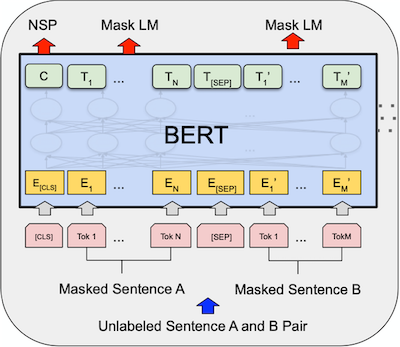

## STEP 1-1 데이터 전처리
---
모델에 들어갈 데이터를 전처리해준다

In [7]:
############ json 포멧 데이터 확인용 함수 #################
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [8]:
# 훈련데이터 확인
train_json_path = path_BERT + 'KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [9]:
## 검증 데이터 확인
dev_json_path = path_BERT + 'KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


In [10]:
########## json 파일을 df 형식으로 바꿔주는 함수
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [11]:
################# train 데이터 확인해보기 #####################
train = squad_json_to_dataframe_train(train_json_path)
train

Reading the json file
processing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


shape of the dataframe is (60407, 6)
Done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


,index,question,context,text,answer_start,c_id
0,6566495-0-0,바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,교향곡,54,0
1,6566495-0-1,바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,1악장,421,0
2,6566495-0-2,바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,베토벤의 교향곡 9번,194,0
3,6566518-0-0,1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,파우스트,15,0
4,6566518-0-1,파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?,1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로...,합창교향곡,354,0
...,...,...,...,...,...,...
60402,6467478-1-1,뉴델리 메탈로 베타락마제가 처음 감염 된 지역은 어디인가?,"유전자의 이름은 인도의 수도 뉴델리의 이름을 따 붙여졌는데, 이는 2009년 용 (...",인도,73,9604
60403,6467478-2-0,균은 유전자를 균에게 전달 할 수있는데 이러한 현상을 나타낸 용어는 무엇인가?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",유전자 전달,253,9605
60404,6467478-2-1,박테리아가 NDM-1 유전자를 가지고 있을때 발생하는 전파를 분석하기위해 사용된 영...,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",37건,129,9605
60405,6490801-2-0,NDM-1 유전자를 가진 박테리아가 감수성을 보인 폴리믹슨 계열 항생제는?,"2010년 8월, 저널 The Lancet Infectious Diseases에 최...",콜리스틴,404,9605


index, question, context, answer, answer_start,	c_id 의 컬럼으로 이뤄진 것을 알 수 있습니다. 

데이터를 확인했으니 띄어쓰기 단위로 정보를 관리할 수 있도록 전처리 하겠습니다.

#### 데이터셋 전처리 (1) 띄어쓰기 단위 정보관리
----


In [12]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
    #만약 c의 값이 공백, 탭, 줄바꿈, 아스키코드 변홚시 공백인 값이면 true
        return True
    return False

In [13]:
########## 띄어쓰기 단위 정보 관리 함수 ####################
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            #공백이면 prev_~값을 true로 전환해주고 -> 밑에 char_~ 값 더해줌
            prev_is_whitespace = True
        else:
            #공백이 아닌 문자라면
            if prev_is_whitespace:
                #만약 앞에가 공백이었으면 word_token에 새로운 값(새 리스트값)으로 추가
                word_tokens.append(c)
            else:
                #앞에가 공백이 아니었다면, 기존에 있던 word_token 뒤에 더해줌
                #공백까지 앞에 word_token으로 들어감
                word_tokens[-1] += c
            #공백이 아닌 문자가 들어왔으니 prev_~값을 false로 전환
            prev_is_whitespace = False
        #공백 유무에 상관없이 기존 생성되어 있는 word_token값에 따라 cahr_~값 추가함
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [14]:
# 한 문장에 대해 띄어쓰기 영역 정보를 표기
string1 = train['question'][0]
word_tokens, char_to_word = _tokenize_whitespace(string1)

for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')
    
print(word_tokens, char_to_word)
print(len(char_to_word))

'바' : 0
'그' : 0
'너' : 0
'는' : 0
' ' : 0
'괴' : 1
'테' : 1
'의' : 1
' ' : 1
'파' : 2
'우' : 2
'스' : 2
'트' : 2
'를' : 2
' ' : 2
'읽' : 3
'고' : 3
' ' : 3
'무' : 4
'엇' : 4
'을' : 4
' ' : 4
'쓰' : 5
'고' : 5
'자' : 5
' ' : 5
'했' : 6
'는' : 6
'가' : 6
'?' : 6
['바그너는', '괴테의', '파우스트를', '읽고', '무엇을', '쓰고자', '했는가?'] [0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6]
30


잘 되는 것을 확인했습니다.

#### 데이터셋 전처리 (2) Tokenize by Vocab
---

자연어 처리를 하는 단계에서 전처리 이후에 tokenizing 단계가 필요한데 BERT에서는 WordPiece tokenizing을 사용합니다. 비슷한 의미로 Byte Pair Encoding이라고 합니다.

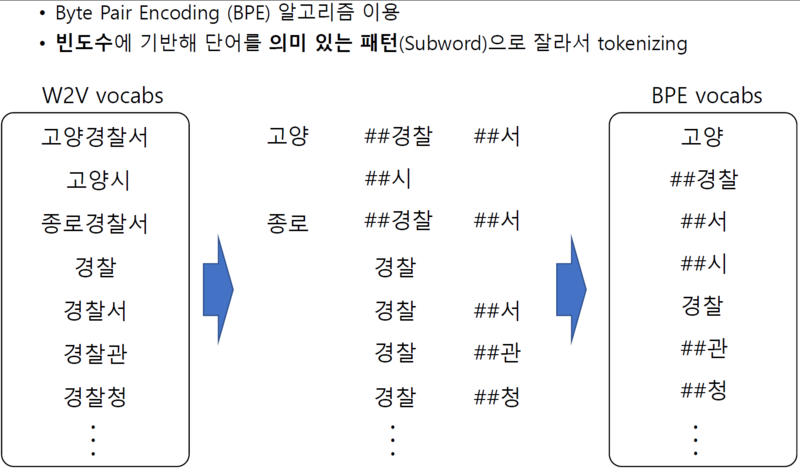


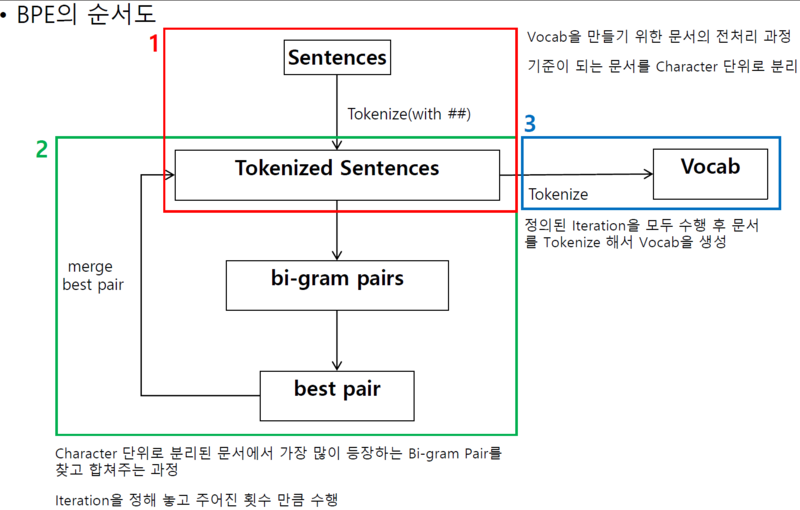

In [15]:
# 보캡 읽어오기
vocab = spm.SentencePieceProcessor()
vocab.load(f'{path_BERT}/ko_32000.model')

# word를 subword로 변경하면서 index 저장
word_to_token = []
context_tokens = []

for (i, word) in enumerate(word_tokens):
    word_to_token.append(len(context_tokens))
    # SentencePiece를 사용해 Subword로 쪼개기
    tokens = vocab.encode_as_pieces(word)
    for token in tokens:
        context_tokens.append(token)
        
context_tokens, word_to_token

(['▁바그너',
  '는',
  '▁괴테',
  '의',
  '▁',
  '파우스트',
  '를',
  '▁읽고',
  '▁무엇을',
  '▁쓰고',
  '자',
  '▁',
  '했',
  '는',
  '가',
  '?'],
 [0, 2, 4, 7, 8, 9, 11])

여기서 word_to_token의 `[0, 2, 5]`란 context_tokens에 쪼개져 담긴 0번, 2번, 5번 토큰인 '▁1839', '▁', '▁읽' 이 어절 단위의 첫 번째 토큰이 된다는 정보를 담아둔 것입니다.

In [16]:
######### SentencePiece 활용 Tokenize 만들기 #########
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        
        for token in tokens:
            context_tokens.append(token)
            
    return context_tokens, word_to_token

In [17]:
print(word_tokens) #처리해야 할 word 입력단위

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token

['바그너는', '괴테의', '파우스트를', '읽고', '무엇을', '쓰고자', '했는가?']


(['▁바그너',
  '는',
  '▁괴테',
  '의',
  '▁',
  '파우스트',
  '를',
  '▁읽고',
  '▁무엇을',
  '▁쓰고',
  '자',
  '▁',
  '했',
  '는',
  '가',
  '?'],
 [0, 2, 4, 7, 8, 9, 11])

#### 데이터셋 전처리 (3) Improve Span
---

KorQuAD 데이터셋에서 context, question, answer를 뽑아 봅니다. KorQuAD 데이터셋은 `질문(question)`과 `지문(context)`을 주고, 지문 영역에서 `정답(answer)`을 찾도록 구성되어 있습니다. 그러므로 정답에 해당하는 지문 영역을 정확히 찾아내는 것이 전처리의 핵심적인 작업이 됩니다.

In [18]:
############### 각 데이터 넣어주기 ###################
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']

answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index : ', answer_start, 'character : ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다.     
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index :  54 character :  교
[answer_end]index:  56 character:  곡


In [19]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 봅시다.
word_tokens, char_to_word = _tokenize_whitespace(context)

print(word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [20]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [21]:
# answer_star와 anser_end로부터 word_start와 word_end를 구함
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end +1]

(14, 14, '교향곡', ['교향곡을'])

정답은 15번째 어절(index=14)에 있었지만 우리가 원하는 정답은 '교향곡을'이 아니니, 이를 처리해줍니다.

In [22]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

#실제 정답인 answer_text도 Subword 기준으로 토큰화 해둡니다.
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [23]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [24]:
# 잘 작동하는지 확인하자
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start : ', token_start, 'token_end : ', token_end)
context_tokens[token_start:token_end + 1]

token_start :  19 token_end :  19


['▁교향곡']

굿...!

#### 데이터셋 전처리 (4) 데이터셋 분리
----
train 데이터셋, dev 데이터셋을 분리하여, 위에서 작성한 `_improve_span()` 함수를 이용해 전처리 후 파일로 저장

In [25]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data['title']
            for paragraph in data['paragraphs']:
                context = paragraph['context']
                context_words, char_to_word = _tokenize_whitespace(context)
                
                for qa in paragraph['qas']:
                    assert len(qa['answers']) == 1
                    qa_id = qa['id']
                    question = qa['question']
                    answer_text = qa['answers'][0]['text']
                    answer_start = qa['answers'][0]['answer_start']
                    answer_end = answer_start + len(answer_text) - 1
                    
                    assert answer_text == context[answer_start : answer_end + 1]
                    
                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]
                    
                    word_answer = " ".join(context_words[word_start : word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer
                    
                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)
                    
                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] -1
                    else:
                        token_end = len(context_tokens) - 1
                    
                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)
                    
                    data = {'qa_id' : qa_id, 'title' : title, 'question' : vocab.encode_as_pieces(question), 'context' : context_tokens, 'answer' : char_answer, 'token_start' : token_start, 'token_end' : token_end}
                    
                    f.write(json.dumps(data, ensure_ascii = False))
                    f.write("\n")
                    

In [26]:
# 전처리를 수행하여 파일로 생성
dump_korquad(vocab, train_json, f'{path_BERT}korquad_train.json')
dump_korquad(vocab, dev_json, f'{path_BERT}korquad_dev.json')

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [27]:
#전처리가 의도대로 잘 되었는지 실제 파일 확인해보기
def print_file(file_name, count = 10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(file_name) as f:
        for i, line in enumerate(f):
            if count <= i :
                break
            print(line.strip())
            
print_file(f'{path_BERT}korquad_train.json')

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

#### 데이터셋 전처리 (5) 데이터 분석 : Question, context, answer
----
원본데이터를 불러와 상기 내용으로 전처리하였습니다. 이후 이상치가 있는지 확인하기 위하여 각각의 길이 분포를 조사해봅니다.

In [28]:
############### 데이터 길이 분포 확인하기 ####################
questions = []
contexts = []
token_starts = []

# train data에서 각 데이터들 입력해주기
with open(f'{path_BERT}korquad_train.json') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data['question'])
        contexts.append(data['context'])
        token_starts.append(data['token_start'])


In [29]:
########## 길이를 측정하기 위한 token count ############
train_question_counts = [len(question) for question in questions]
train_context_counts = [len(context) for context in contexts]
train_answer_starts = token_starts

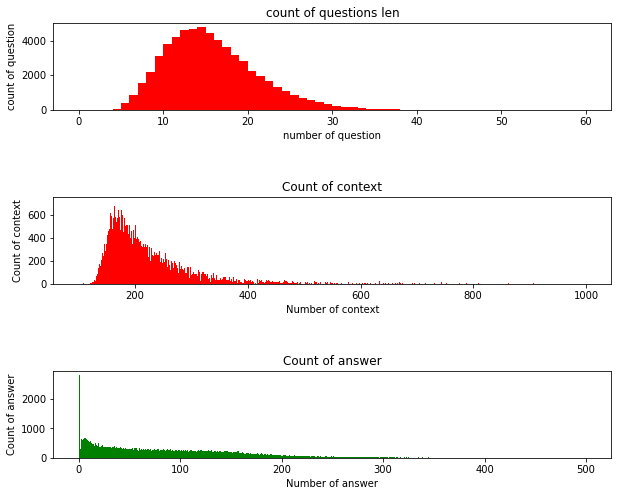

In [30]:
############### 각 항목의 분포 시각화 ##############
plt.figure(figsize = (10, 8))

# Quenstions
plt.subplot(3,1,1)
plt.hist(train_question_counts, bins = 60, range = [0,60], facecolor = 'r', label = 'Train')
plt.title('count of questions len')
plt.xlabel('number of question')
plt.ylabel('count of question')

#Context
plt.subplot(3,1,2)
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
plt.title('Count of context')
plt.xlabel('Number of context')
plt.ylabel('Count of context')

#Answer
plt.subplot(3,1,3)
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
plt.title('Count of answer')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')

plt.subplots_adjust(wspace = 1, hspace = 1)
plt.show()

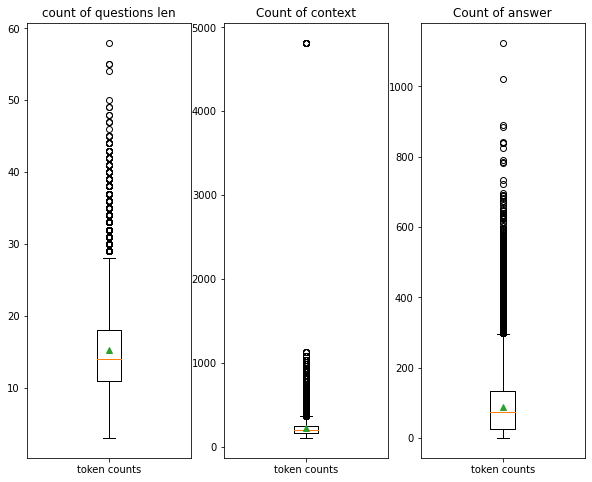

In [31]:
############### 각 항목의 분포 시각화 - Box lot ##############
plt.figure(figsize = (10, 8))

# Quenstions
plt.subplot(1,3,1)
plt.title('count of questions len')
plt.boxplot(train_question_counts, labels = ['token counts'], showmeans = True)

#Context
plt.subplot(1,3,2)
plt.title('Count of context')
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)

#Answer
plt.subplot(1,3,3)
plt.title('Count of answer')
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

In [32]:
############### 각 항목의 분포 확인 #####################
print('=='*10, 'Questions 길이 분포', '=='*10)
print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")
percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")
print('\n','=='*10, 'Context 길이 분포', '=='*10)
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")
percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")
print('\n','=='*10, 'Answer 길이 분포', '=='*10)
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")
percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

==================== Questions 길이 분포 ====================
question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50

 ==================== Context 길이 분포 ====================
context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50

 ==================== Answer 길이 분포 ====================
answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


#### 데이터셋 전처리 (6) 데이터 로드
---
지금까지 만든 데이터셋을 메모리에 로드합니다.

In [33]:
################### 데이터 로드 ####################
train_json = os.path.join(path_BERT, "korquad_train.json")
dev_json = os.path.join(path_BERT, "korquad_dev.json")

In [34]:
################# 생성한 데이터셋 파일을 메모리에 로딩하는 함수 ##################
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            #최대길이에 -3(CLS, SEP, SPE)
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ## 여기가 패딩
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            # 질문 길이만큼 0을 주고, context길이만큼 1로 나눠주고!
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            ## 여기가 패딩
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [35]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class 
    :param dict: config dictionary                                                                                                                                                                                                                                                                                                                                                                                             
    """
    #config = Configuration File
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

In [36]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

## STEP 1-2. BERT model 구조
---
- Transformer 모델은 Self-Attention 으로 이루어진 Encoder-Decoder 구조를 가지고 있어서 번역기 모델 형태를 구현하는데 좋은 성능을 냄 (지난 [E-11 챗봇 모델](https://github.com/Chabbbbbo/EXPLORATION/blob/main/EX-11/%5BE-11%5D%20Creative%20a%20Korean%20Chatbot.ipynb) 참고) 

- **BERT는 여기서 Transformer Encoder 구조만을 활용**합니다. Layer 개수는 12개 이상으로 늘리고, 전체적으로 파라미터 크기가 훨씬 커지긴 했지만 기본적인 구조는 동일함

- Decoder가 없는 대신, BERT의 출력은 `Mask LM`와 `NSP`의 2 문제를 해결하도록 Pre-training 됨

- BERT의 Pre-training과 Fine-Tuning의 구조
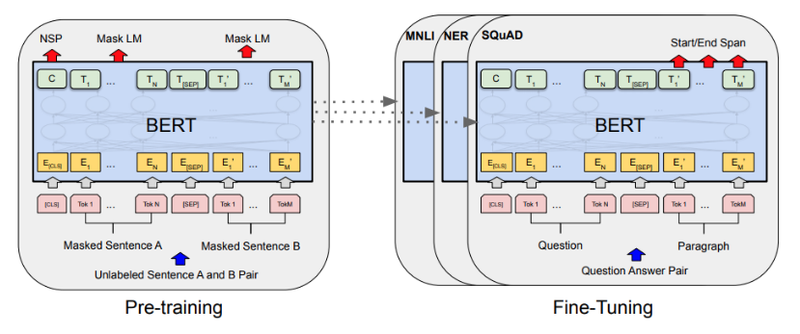  


- **Mask LM** 
    - BERT의 Input 단어(토큰)값 중 15%를 임의로 선택하여 `<MASK>`화 하여 순방향/역방향을 모두 참고하여 `<MASK>`된 단어가 무엇인지 예측하는 것
    - 예) `나는 <mask> 먹었다` -> `<MASK>`가 `밥을`임을 맞추는 것
    - 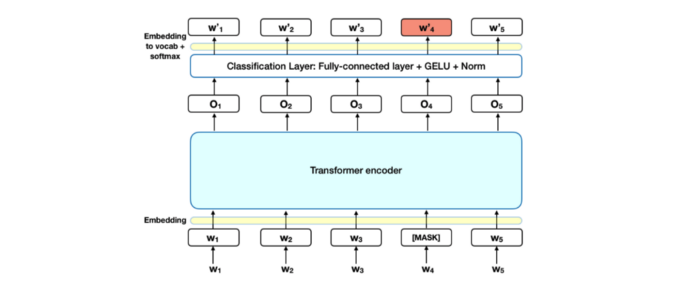

- **NSP(Next Sentence Prediction)**
    - Input으로 2문장이 들어왔을 때 `<SEP>` 토큰을 경계로 좌우 문장이 연결되는데, 이 두 문장이 순서대로 이어지는지 맞추는 것
    - 그 결과값을 첫번째 바이트의 NSP 결과값을 리턴함. (상기 그림 Pre-training 참고)  
    - 첫 번째 문장이 두 번째 문장 뒤에 오는 경우 1을 반환하고 두 번째 문장이 첫 번째 문장 뒤에 오는 경우 0을 반환함

### 1) EMBEDDING part
---
- Input Embedding 구조  
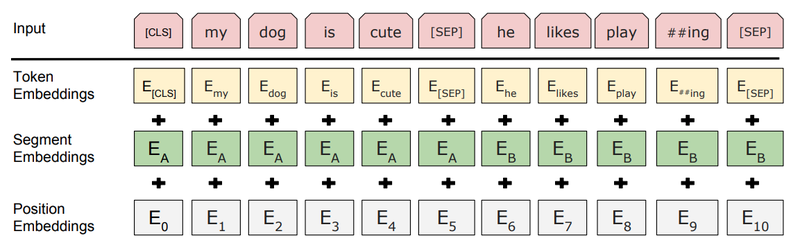  
- 2문장의 text가 상기 그림의 Input처럼 주어졌을 때, **실제 모델엔 Token, Segment, Position Embedding의 3가지가 더해진 형태로 입력**됨

- **각 레이어 설명**
    - **Token Embedding** : 텍스트를 tokenizer를 통해 쪼개 token으로 embedding하는 것
    - **Segment Embedding** : 기존 Transformer에 없는 독특한 임베딩으로, 각 단어가 속한 문장을 표시해 주는 것. Q&A 문제처럼 문장이 Question 부분인지, Context 문장에 속하는지 구분이 필요한 경우 유용하게 사용됨.
    - **Position Embedding** : 기존 Transformer의 position embedding과 동일하게 단어의 위치를 알려주도록 embedding 하는 것

In [37]:
############# 유틸리티 함수 정의 ##############

############# 패드 위치 알려주는 함수 ###################
# token과 i_pad가 같으면 1, 아니면 0으로 바꿔줌으로 mask위치 나타냄
def get_pad_mask(tokens, i_pad = 0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad -> 뒤에서 config.i_pad : 0으로하는데 -> 패드값을 0으로 하겠다는거
    :return mask: pad mask (pad: 1, other: 0)
    """

    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis = 1)
    
    return mask


#사칙연산 등의 간단한 함수에서 @tf.function을 사용한다면 처리속도가 상당히 증가한다.
#func may use data-dependent Python control flow statements, 
#including if, for, while break, continue and return:
@tf.function(experimental_relax_shapes = True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

def kernel_initializer(stddev = 0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    
    return tf.zeros_initializer

#### ※참고 : GELU란?

정규분포의 누적분포함수로 RELU보다 0 인근 지점에서 원만하게 변화하여 학습 성능을 높인다고 한다 ('한국어 임베딩')

- 함수 모양
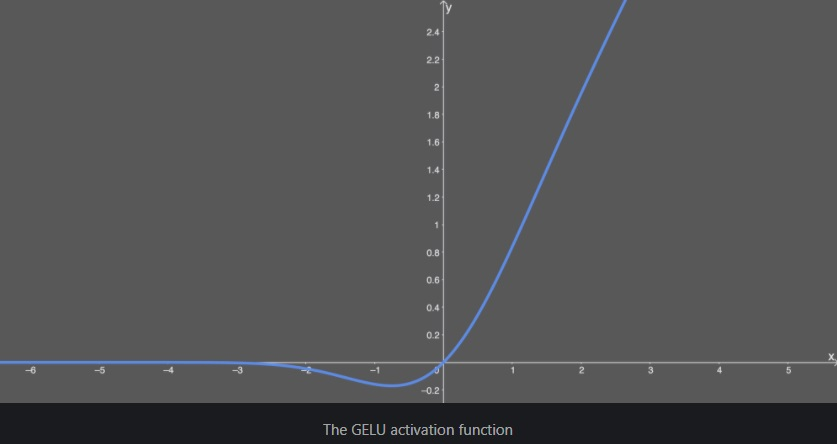

- 수식  
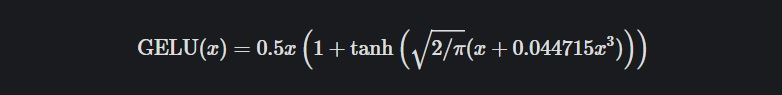

- 활성화 함수 GELU, ELU, ReLU의 비교
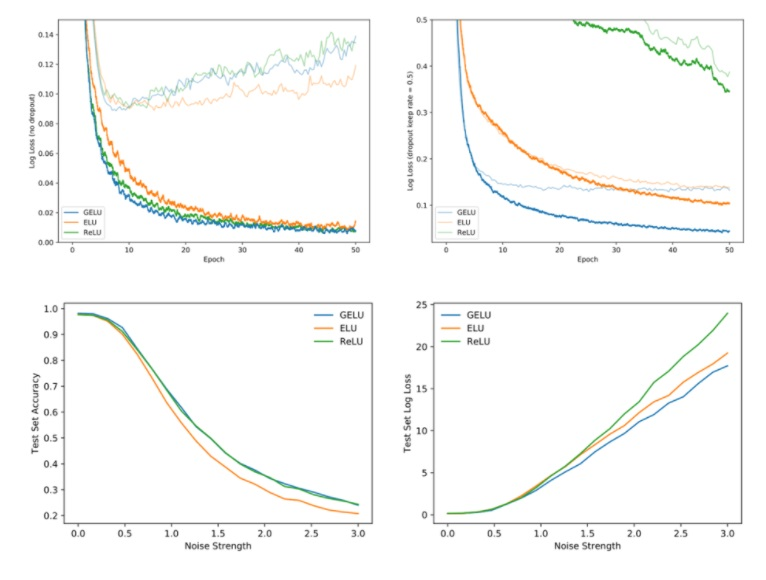

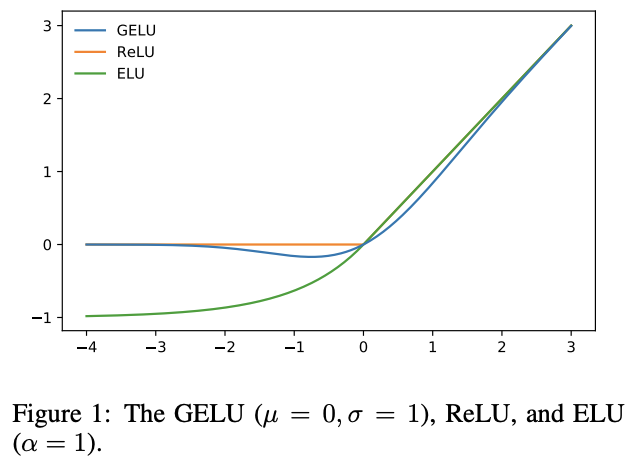  
여러 결과들을 보면 GELU가 RELU, ELU 등의 타 활성화 함수들보다 빠르게 수렴, 낮은 오차를 보여줌  

또한 GELU는 음수에 대해서도 미분이 가능해 약간의 그래디언트를 전달할 수 있음


In [38]:
# 하나의 함수에서 mode를 나눠 mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name = 'weight_shared_embedding'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name = name)
        
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        
        with tf.name_scope('shared_embedding_weight'):
            self.shared_weights = self.add_weight(
                'weights',
                #행 : n_vocab 수, 
                #열 : d_model의 사이즈
                shape = [self.n_vocab, self.d_model],
                initializer = kernel_initializer()
            )
            
    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        #임베딩, 리니어 한번에 처리할 수 있는 mode 함수!
        
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == 'embedding':
            return self._embedding(inputs)
        #mode가 linear일 경우 linear 실행
        elif mode == 'linear':
            return self._linear(inputs)
        #mode가 기타일 경우 오류발생
        else:
            raise ValueError(f'mode{mode} is not valid')
            
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed
    
    def _linear(self, inputs): # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        # (bs * n_seq, d_model)
        inputs = tf.reshape(inputs, [-1, self.d_model]) 
        #input * weight 곱해줌
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b = True)
        # (bs, n_seq, n_vocab)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab ])  
        
        return outputs
    

In [39]:
######### positional Embedding ###########
# tansformer에서 처럼 위치를 알려주는 임베딩
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    
    def __init__(self, config, name = 'position_embedding'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name = name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer = kernel_initializer())
        
    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis = 1, exclusive = True), tf.int32)
        embed = self.embedding(position) #position embedding값
        
        return embed
    

#### Scale Dot Attention
---
스케일드 닷 프로덕트 어텐션(=벡터 내적) 함수 구현하기
- 트랜스포머는 어텐션에 쿼리, 키, 벨류값을 수식에 넣어 단어간의 유사도를 나타냄
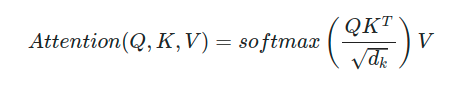  

- 먼저 쿼리와 키의값을 내적(=Q와 K의 전치 행렬을 곱함 하여 값을 구함
- dk의 제곱근으로 나눠 스케일링을 해주고 벨류값을 곱해 어텐션 벡터를 얻음
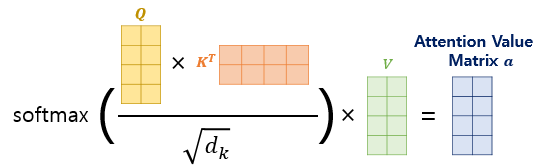

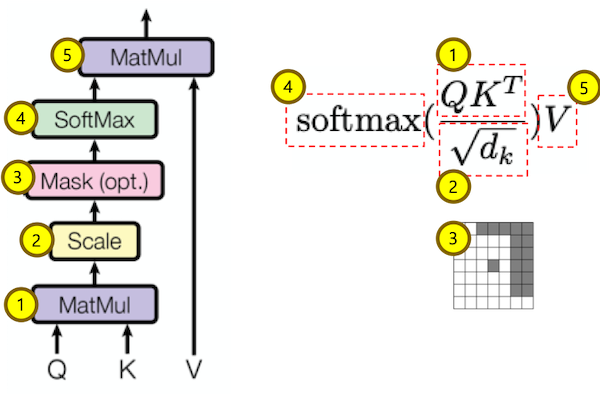

In [40]:
######### 스케일 닷 어텐션 ############

class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name = 'scale_dot_product_attention'):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name = name)
        
    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        #Q, K 곱해 가중치 구함 (1)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        #분모의 루트부분 (2)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        #QKt/루트dk ()부분
        attn_scale = tf.math.divide(attn_score, scale)
        #(3)부분
        attn_scale -= 1.e9 * attn_mask
        #softmax 함수 적용 (4)
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        #최종 어텐션은 가중치와 Value의 닷 프로덕트(5)
        attn_out = tf.matmul(attn_prob, V)
        
        return attn_out

#### Multi Attention
---
셀프 어텐션을 멀티(다각도)로 분석할 수 있도록 병렬 어텐션 함수를 구현

- 기본 구조  
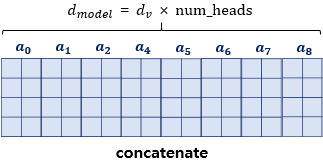  
    - 멀티 병렬 수를 `num_heads` 값으로 넣어줌
    - 기본 (입력 문장 수, 임베딩 벡터 차원(`d_model`))의 벡터들이 있는데, 트랜스포머는 이렇게 입력된 문장 행렬을 `num_heads`의 수만큼 쪼개서 어텐션을 수행함
    - 그럼 어텐션 값이 `num_heads`(병렬수) 만큼 생성되고, 이를 `concat`하여 하나로 합쳐준다.
    - 그럼 결국 다시 열의 값은 `d_model`의 수로 돌아가게 된다.  
(마치 문제지를 나눠서 푼 후, 마지막에 결과를 합치는 느낌)

- BERT 코드 모델 설명
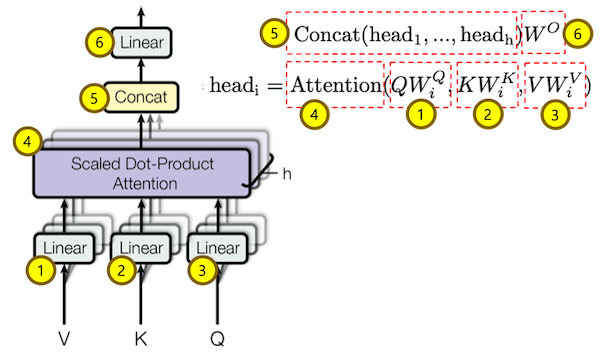

In [41]:
###############멀티 헤드 어텐션 함수 ######################
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    
    def __init__(self, config, name = 'multi_head_attention'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name = name)
        
        #임베딩 벡터 차원(d_model)
        self.d_model = config.d_model
        #멀티로 나눌 수 (num_head)
        self.n_head = config.n_head
        #헤드의 차원수! d_model / n_head...!
        self.d_head = config.d_head
        
        #Q, K, V input dense layer (각각의 가중치 값 처리한 값)
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer = kernel_initializer(), bias_initializer = bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name = 'self_attention')
        
        #output dense layer (합친 d_model의 가중치 까지 한 값을 말하는 것)
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer = kernel_initializer(), bias_initializer=bias_initializer())
        
        
    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        batch_size = tf.shape(Q)[0]
        ##### Q, K, V값을 multi head로 나눠줌
        # (bs, n_head, Q_len, d_head)
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3]) 
        # (bs, n_head, K_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3]) 
        # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  
        
        #Attention Mask도 Multi Head로 변경
        attn_mask_m = tf.expand_dims(attn_mask, axis = 1)
        
        #Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m) # (bs, n_head, Q_len, d_head)
        
        #transpose and linear (여기가 합치면서 리니어 거치는건가?)
        attn_out_m = tf.transpose(attn_out, perm = [0, 2, 1, 3]) # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head]) # (bs, Q_len, d_model)
        #W0랑 dense
        attn_out = self.W_O(attn_out) 

        return attn_out

#### Feed Forward
---
하나의 인코더층은 상기 만들어 놓은 self-attention층과 feed forward neural network 층으로 구성되어 있음.   
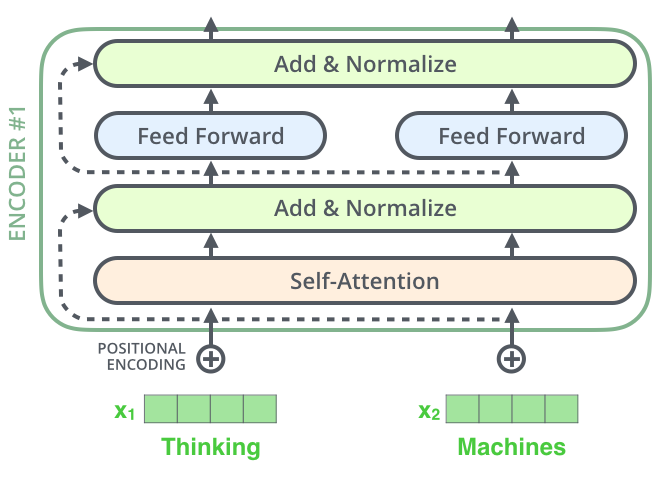  

위 그림에서 Feed Forward 부분 상세  
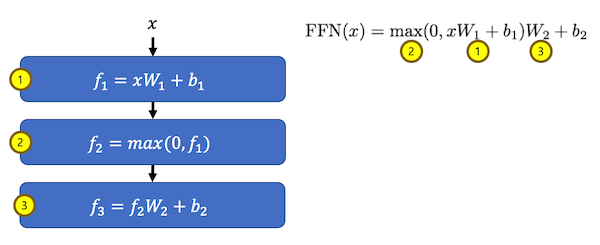

In [42]:
################Position Wise Feed Forward##################
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name = 'feed_forward'):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name = name)
        
        #d_ff 는 feed forward dim
        #gelu층
        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation = gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        #dense층
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs)) # 인풋 -> gelu -> d_model로 dense
        
        return ff_val

### 2) Encoder Layer
---
위의 층들을 합쳐서 인코더 레이어를 만듦

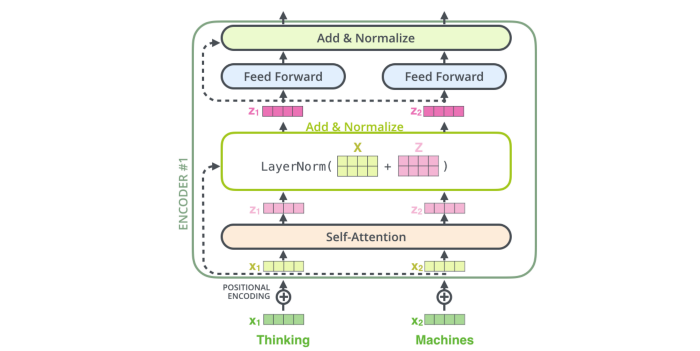

In [43]:
################### Encoder Layer ###################
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        #self attention
        self.self_attention = MultiHeadAttention(config)
        #normalization
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        # FF : 인풋 -> gelu -> d_model로 dense
        self.ffn = PositionWiseFeedForward(config)
        #normalization
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
    
        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        #multi head attention으로 self attention 진행
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        #self attention 후 norm/dropout
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))
        
        #FF : 인풋 -> gelu -> d_model로 dense
        ffn_val = self.ffn(norm1_val)
        #norm/dropout
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out
        

### 3) BERT model
---
만들어진 encoder를 쌓아 BERT model을 만들어 줍니다.

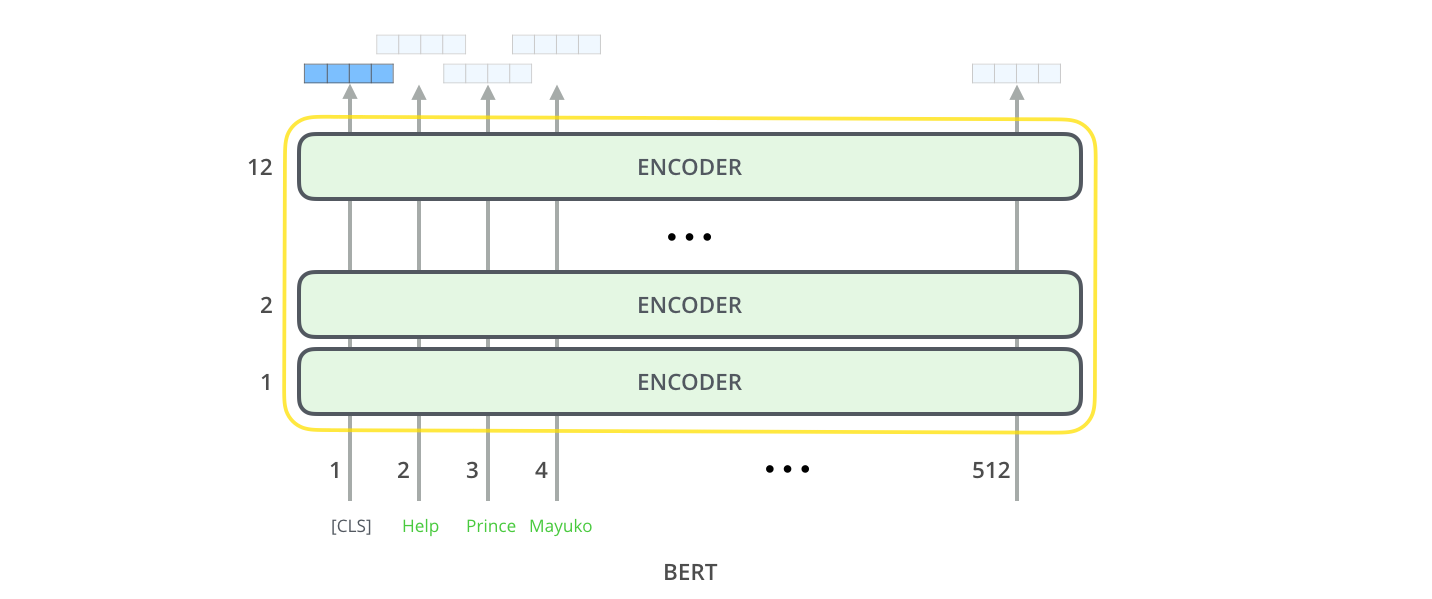

Transformer의 바닐라 인코더와 마찬가지로 BERT는 스택에 sequence word를 계속해서 입력으로 사용합니다. 
각 계층은 self-attention을 적용하며, 그 결과를 feed forward network로 보내고 다음 인코더로 전달하는 것을 반복합니다.
(BERT-base는 12layer, BERT-large는 24layer)

In [44]:
############# 레이어 합쳐서 BERT 만들기 ######################
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        # 위에서 정의한 layer 함수들
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        # layers! 인코더 레이어 반복함
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)
        
    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        #마스크 입히고 학습 후 드롭아웃
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)
        #최종 임베딩
        enc_embed = self.get_embedding(enc_tokens, segments)
        enc_out = self.dropout(enc_embed)
        #반복
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        
        #encoder의 학습결과(enc_out)의 첫 번째([CLS]) Token을 logits_cls로 저장
        logits_cls = enc_out[:,0]
        #encoder의 학습결과를 LM(마스크한 것으로 학습한 내용)으로 받아서 저장함
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    #인풋값의 3가지 임베딩 값을 더해서 최종 embedding값을 만듦
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        
        return embed
        

### 4) BERT의 Finetunning For KorQuAD
---
BERT는 이미 총3.3억 단어(BookCorpus + Wikipedia Data)의 거대한 코퍼스를 정제하고, 임베딩하여 학습시킨 Pretraining 모델
- 거기에 마지막 layer를 task에 맞게 쌓아 원하는 task에 사용함
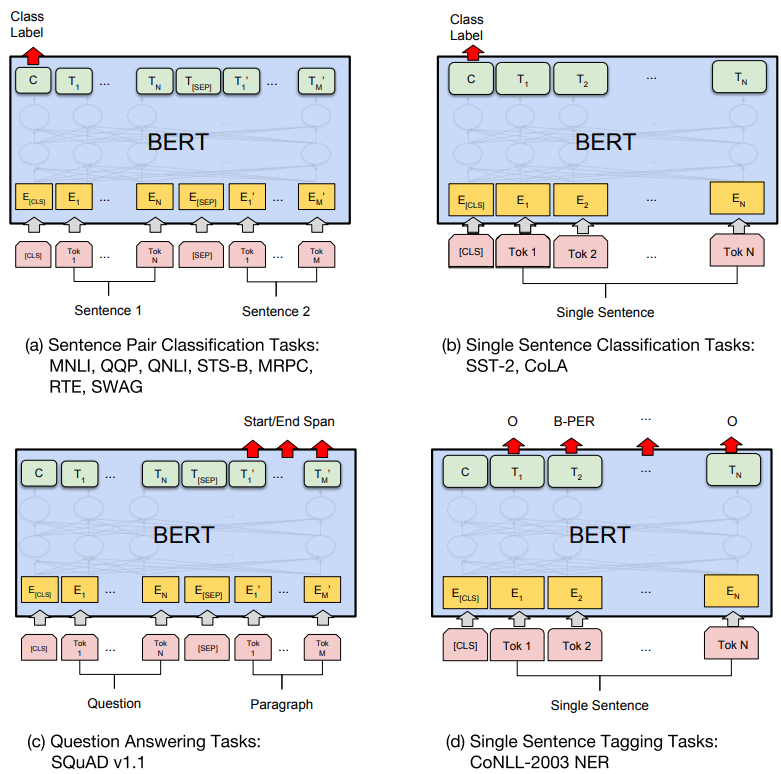  
- 만들고자하는 KorQuAD를 위한 모델을 만들어준다

In [45]:
############## KorQuAD를 위한 BERT 모델 구현 ################
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        #BERT실행! 후 받은 값을 cls, lm값으로 저장해줌
        logits_cls, logits_lm = self.bert(enc_tokens, segments)
        
        hidden = self.dense(logits_lm) # (bs, n_seq, 2)

        # (bs, n_seq, 1), (bs, n_seq, 1) start와 end 2가지 결과를 냄
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  
        # start
        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
        # end
        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

## STEP 1-3 Pretrained model 적용하기
---
로드한 bert_pretrain_32000 hdf 파일을 사용하여 쌓아온 BERT model에 적용한다 

In [46]:
########### model에 config를 사용하기 위한 함수 ################
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class 
    :param dict: config dictionary                                                                                                                                                                                                                                                                                                                                                                                             
    """
    #config = Configuration File
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_query_length': 64, 'max_seq_length': 384}

In [47]:
########## config값 설정########
config = Config({'d_model': 512, 'n_head': 8, 'd_head': 64, 'dropout': 0.1, 'd_ff' : 1024, 'layernorm_epsilon': 0.001, 'n_layer' : 6, 'n_seq' : 384, 'n_vocab' : 0, 'i_pad' : 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 512,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 8,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007}

### Config값 설명
우리의 작고 기여운 버트쓰 Our Tiny Bert (29M parameters) 

- d_model : 512, (모델의 차원수)
- n_head : 8, (멀티 어텐션 헤드 수)
- d_head : 64, (멀티 어텐션 헤드의 차원수)
- dropout : 0.1, (드랍아웃 퍼센트)
- d_ff : 1024, (feed forward 차원수)
- layernorm_epsilon : 0.001, (정규화의 epsilon 값)
- n_layer : 6, (레이어수)
- n_seq : 384,(최대 문장 길이)
- n_vocab : 32007, (보캡수)
- i_pad : 0 (tokens내의 mask index)


In [48]:
#############렛츠고 미니배치 #############
bert_batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)


In [49]:
print('train_labels 값:',train_labels)
print('=='*20)
print('train_labels[0] 값:',len(train_labels[0])) # 59977개 0이 없음.
print('=='*20)
print('train_inputs 값:',train_inputs) #진짜 입력 데이터인것같고??
print('=='*20)
print('train_inputs[0] 값:',len(train_inputs[0])) #59977 
print('=='*20)
print(train_dataset) # (((None, 384), (None, 384)), ((None,), (None,)))
print('=='*20)
print(dev_labels) # 마스킹할 내용인가 
print('=='*20)
print('dev_labels[0] 값:',len(dev_labels[0]))
print('=='*20)
print(dev_inputs) # 패딩된 내용
print('=='*20)
print(train_dataset) #(((None, 384), (None, 384)), ((None,), (None,))) train과 동일

train_labels 값: (array([ 37, 184,  98, ...,  74, 190,  35]), array([ 37, 185, 102, ...,  75, 191,  44]))
train_labels[0] 값: 59977
train_inputs 값: (array([[    5, 15798,    10, ...,     0,     0,     0],
       [    5, 15798,    10, ...,     0,     0,     0],
       [    5, 15798,    19, ...,     0,     0,     0],
       ...,
       [    5, 21666,    19, ...,     0,     0,     0],
       [    5,   964, 16865, ...,     0,     0,     0],
       [    5,   365,    15, ...,     0,     0,     0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))
train_inputs[0] 값: 59977
<BatchDataset element_spec=((TensorSpec(shape=(None, 384), dtype=tf.int64, name=None), TensorSpec(shape=(None, 384), dtype=tf.int64, name=None)), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>
(array([ 17,  7

- 위의 train dataset에서 shuffle(10000)이 들어간 이유???  
tensor slices를 찾다보니 아래와 같은 말이 나온다
> NLP 애플리케이션에서 텐서 슬라이싱을 사용하여 훈련하는 동안 워드 마스킹을 수행할 수 있습니다. 예를 들어 각 문장에서 마스킹할 단어 인덱스를 선택하고 해당 단어를 레이블로 선택한 다음 선택한 단어를 마스크 토큰으로 교체하여 문장 목록에서 훈련 데이터를 생성할 수 있습니다.

> x = tf.placeholder(tf.float32, shape=[None, 2])  
dataset = tf.data.Dataset.from_tensor_slices(x)  

> tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다. 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.


#### 참고) 왜 start / end를 구할까?
> 앞서 우린 정답이 단어가 아닌 문장으로 나오는 것도 있음을 확인했다. 그럼 start 토큰 뿐만 아니라 end 토큰의 값을 정확히 구하는 것도 정답에 영향을 준다는 것을 알았다. 그 때문에 start와 end를 모델이 얼마나 정확히 구하는지 loss와 acc를 계산하는 것.

## STEP 2. pretrained model finetune 하기
---
pretrained model을 가지고와서 finetuning을 진행하자

In [50]:
# 모델 설정
model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(path_BERT, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (BERT)                 multiple                  29202944  
                                                                 
 dense_36 (Dense)            multiple                  1026      
                                                                 
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


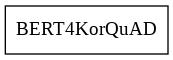

In [51]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes = True)

In [52]:
##################### train epoch #######################
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name = 'start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name = 'end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name = 'start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name = 'end_acc')
    
    p_bar = tqdm(dataset)
    
    #dataset에서 데이터 가져오기
    for batch, ((enc_tokens, segment), (start_labels, end_labels)) in enumerate(p_bar):
        #. tf.GradientTape는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"
        #그 다음 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 
        #테이프에 "기록된" 연산의 그래디언트를 계산
        with tf.GradientTape() as tape:
             #모델에서 나온 start값과 end값을 받아옴
            start_outputs, end_outputs = model(enc_tokens, segment)
            #start라벨과 실제 start_output을 비교해서 loss 값을 구함
            start_loss = loss_fn(start_labels, start_outputs)
            #end라벨과 실제 end_output을 비교해서 loss 값을 구함
            end_loss = loss_fn(end_labels, end_outputs)
            #두 loss 값을 더해서 토탈 loss를 구함
            loss = start_loss + end_loss
            
            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    
    p_bar.close()
    
    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [53]:
##################### 평가(eval) epoch #######################
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [54]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

이제 모델의 epoch를 설정하여 모델을 돌려주자!

In [130]:
best_acc = .0
patience = 0

#시각화를 위한 리스트
start_losses = []
end_losses = []
start_accuracy = []
end_accuracy = []

for epoch in range(5):

    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
        
    start_losses.append(start_loss)
    end_losses.append(end_loss)
    start_accuracy.append(start_acc)
    end_accuracy.append(end_acc)

    #정확도가 증가하지 않으면 patience 올리고 2 이상이면 early stop 하기
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(path_BERT, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.6809, 1.8926, acc: 0.5713, 0.5356
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6820, 1.9342, acc: 0.5806, 0.5434
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8587, 2.0676, acc: 0.5583, 0.5312


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.0324, 2.2475, acc: 0.5606, 0.5235
early stopping


In [131]:
########### 결과 dataframe #############
data = {
    "start_losses": start_losses,
    "end_losses": end_losses,
    "start_accuracy": start_accuracy,
    "end_accuracy": end_accuracy,
}

test1 = pd.DataFrame(data)
print(test1)

                                    start_losses  \
0  tf.Tensor(1.6809297, shape=(), dtype=float32)   
1   tf.Tensor(1.682024, shape=(), dtype=float32)   
2  tf.Tensor(1.8586551, shape=(), dtype=float32)   
3  tf.Tensor(2.0323546, shape=(), dtype=float32)   

                                      end_losses  \
0   tf.Tensor(1.892568, shape=(), dtype=float32)   
1  tf.Tensor(1.9341588, shape=(), dtype=float32)   
2  tf.Tensor(2.0676193, shape=(), dtype=float32)   
3  tf.Tensor(2.2474868, shape=(), dtype=float32)   

                                   start_accuracy  \
0   tf.Tensor(0.5712781, shape=(), dtype=float32)   
1  tf.Tensor(0.58058286, shape=(), dtype=float32)   
2   tf.Tensor(0.5582865, shape=(), dtype=float32)   
3   tf.Tensor(0.5605688, shape=(), dtype=float32)   

                                     end_accuracy  
0  tf.Tensor(0.53563905, shape=(), dtype=float32)  
1  tf.Tensor(0.54336375, shape=(), dtype=float32)  
2     tf.Tensor(0.53125, shape=(), dtype=float32)  
3   

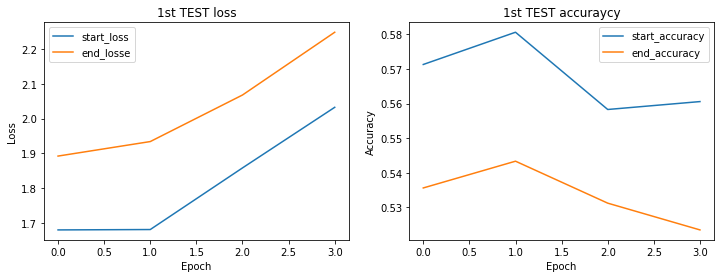

In [132]:
########### loss값 시각화 하기 ###############
plt.figure(figsize=[12, 4])

plt.subplot(1,2,1)
plt.plot(start_losses, label="start_loss")
plt.plot(end_losses, label="end_losse")
plt.title('1st TEST loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

########### accuracy값 시각화 하기 ###############
plt.subplot(1,2,2)
plt.plot(start_accuracy, label="start_accuracy")
plt.plot(end_accuracy, label="end_accuracy")
plt.title('1st TEST accuraycy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

우선 1차 TEST를 마쳤다.  

이를 통해 퀴즈풀이의 실제 결과를 확인해보자. 

## STEP 3. Inference 수행하기
---
finetuning된 model을 사용하여 실제 퀴즈풀이 결과를 확인해보자. 

In [64]:
############### 입력에대한 답변을 만드는 함수 ###################
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    #Question 입력 토큰
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    #Context 입력 토큰
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    # 질문과 context를 붙혀 토큰을 만듦
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    # 토큰화
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    #question은 0, context는 1로 표시해서 세그먼트를 나눔
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    #모델에 투입!
    y_start, y_end = model(np.array([token_ids]), np.array([segments]))

    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    #받은 answer start와 end를 붙여 answer토큰을 만듦
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    #answer token-> vocab
    return vocab.decode_pieces(answer_tokens)

In [65]:
dev_json = os.path.join(path_BERT, "korquad_dev.json")

answer_len, answer_predict_len = [], []

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            answer_len.append(answer)
            answer_predict_len.append(answer_predict)
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

오.... 꽤나 근접한 값을 내는 것 같다.  

## STEP 4. 학습 경과 시각화 비교 분석
---
확실히 정답을 정확하게 내는 것들은 단어가 일치하지만 아쉬운 답변은  

정답 : 임수경  
예측 : 임수경을  

처럼 end token을 맞추지 못해서 accuracy가 떨어진다. 이것에 착안해서 뽑은 정답률을 단순 비교하기 위해 정답/예측값의 길이차로 얼마나 정답에 근접한지를 시각화 해보기로했다.

In [151]:
len(answer_len)

54

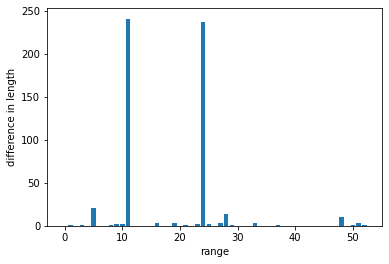

In [166]:
differnt_len_list = []
number = range(53)
for i in number:
    differnt_len = len(answer_predict_len[i]) - len(answer_len[i])
    differnt_len_list.append(differnt_len)

#절댓값으로 변경
len_list = list(map(abs,differnt_len_list))

fig = plt.figure()
x = range(0, 53)
y = len_list
plt.xlabel('range')
plt.ylabel('difference in length')
plt.bar(x, y)
plt.show()

눈에 확 들어오지 않는다.... 차이가 있는 것과 없는 것을 나눠 count로 해봐야겠다.

<BarContainer object of 2 artists>

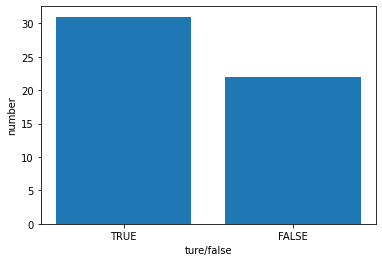

In [177]:
differnt_len_list = []
number = range(53)
for i in number:
    if len(answer_predict_len[i]) == len(answer_len[i]):
        differnt_len_list.append('TRUE')
    else:
        differnt_len_list.append('FALSE')

num_true = differnt_len_list.count('TRUE')
num_false = differnt_len_list.count('FALSE')

######### 시각화 ############
fig = plt.figure()
x = ['TRUE', 'FALSE']
y = num_true, num_false

plt.xlabel('ture/false')
plt.ylabel('number')
plt.bar(x, y)

## STEP 5. parameter 변경
---
- [parameter 변경 논문 리뷰](
https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html) 내용을 통해 Adam W가 Adam보다 좋다는 것을 확인해서 한번 비교해보기로 했다. 

- 1행: Epochs에 따른 Adam과 AdamW의 훈련 손실(1열) / 테스트 에러(2열)
2행 1열: 
λ
값에 따른 Adam과 AdamW의 테스트 에러
2행 2열: 훈련 손실과 테스트 에러

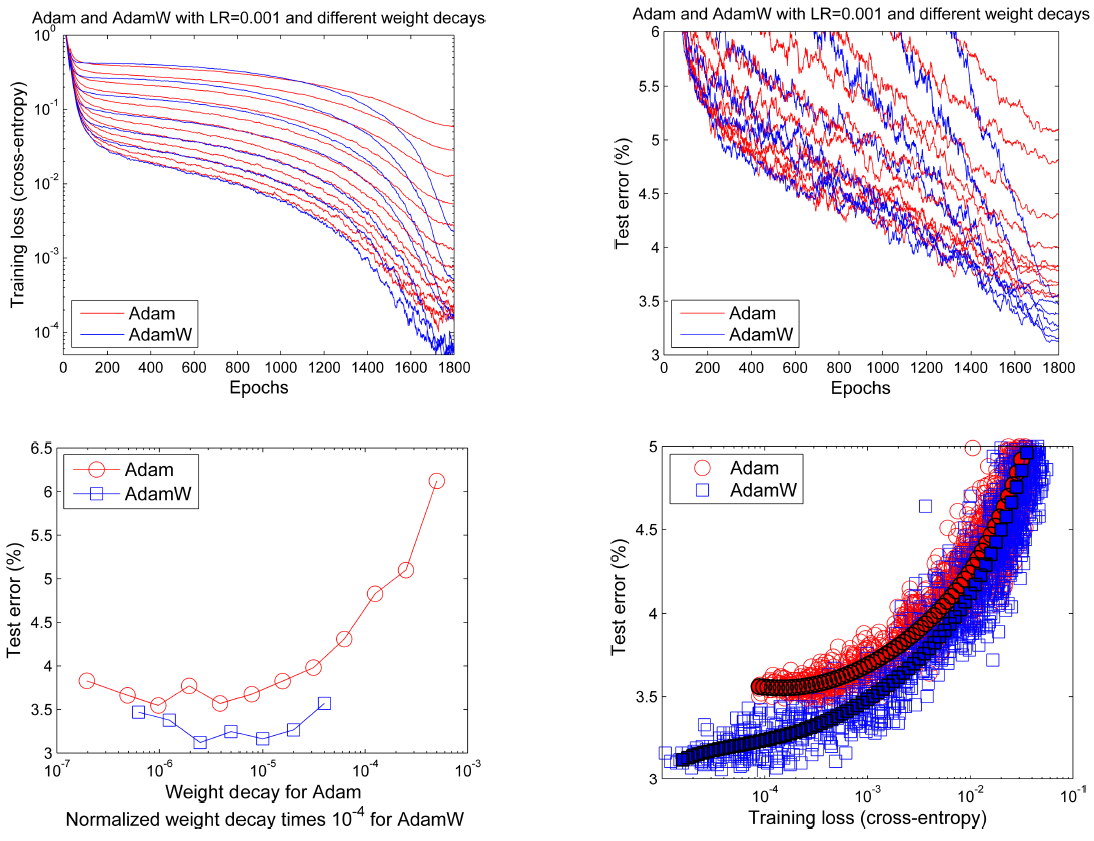

In [55]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer_2 = tfa.optimizers.AdamW(learning_rate=5e-4, weight_decay = 0.001)

In [56]:
best_acc = .0
patience = 0

#시각화를 위한 리스트
start_losses_AdamW = []
end_losses_AdamW = []
start_accuracy_AdamW = []
end_accuracy_AdamW = []

for epoch in range(5):

    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
        
    start_losses_AdamW.append(start_loss)
    end_losses_AdamW.append(end_loss)
    start_accuracy_AdamW.append(start_acc)
    end_accuracy_AdamW.append(end_acc)

    #정확도가 증가하지 않으면 patience 올리고 2 이상이면 early stop 하기
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(path_BERT, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.8199, 2.0504, acc: 0.5332, 0.4991
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.8265, 1.9798, acc: 0.5595, 0.5212
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.7108, 1.9302, acc: 0.5774, 0.5370
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 1.8889, 2.0811, acc: 0.5767, 0.5337


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.2194, 2.4731, acc: 0.5683, 0.5286
early stopping


In [57]:
########### 결과 dataframe #############
data_AdamW = {
    "start_losses": start_losses_AdamW,
    "end_losses": end_losses_AdamW,
    "start_accuracy": start_accuracy_AdamW,
    "end_accuracy": end_accuracy_AdamW,
}

test2 = pd.DataFrame(data_AdamW)
print(test2)

                                    start_losses  \
0  tf.Tensor(1.8198695, shape=(), dtype=float32)   
1  tf.Tensor(1.8264512, shape=(), dtype=float32)   
2  tf.Tensor(1.7107983, shape=(), dtype=float32)   
3  tf.Tensor(1.8888878, shape=(), dtype=float32)   
4  tf.Tensor(2.2193732, shape=(), dtype=float32)   

                                      end_losses  \
0  tf.Tensor(2.0503774, shape=(), dtype=float32)   
1  tf.Tensor(1.9798181, shape=(), dtype=float32)   
2  tf.Tensor(1.9302226, shape=(), dtype=float32)   
3  tf.Tensor(2.0810642, shape=(), dtype=float32)   
4  tf.Tensor(2.4731393, shape=(), dtype=float32)   

                                   start_accuracy  \
0   tf.Tensor(0.5331812, shape=(), dtype=float32)   
1   tf.Tensor(0.5595155, shape=(), dtype=float32)   
2  tf.Tensor(0.57742274, shape=(), dtype=float32)   
3   tf.Tensor(0.5767205, shape=(), dtype=float32)   
4   tf.Tensor(0.5682935, shape=(), dtype=float32)   

                                     end_accuracy  
0  

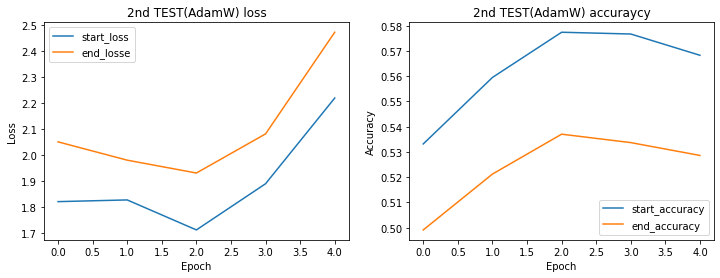

In [62]:
########### loss값 시각화 하기 ###############
plt.figure(figsize=[12, 4])

plt.subplot(1,2,1)
plt.plot(start_losses_AdamW, label="start_loss")
plt.plot(end_losses_AdamW, label="end_losse")
plt.title('2nd TEST(AdamW) loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

########### accuracy값 시각화 하기 ###############
plt.subplot(1,2,2)
plt.plot(start_accuracy_AdamW, label="start_accuracy")
plt.plot(end_accuracy_AdamW, label="end_accuracy")
plt.title('2nd TEST(AdamW) accuraycy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [66]:
dev_json = os.path.join(path_BERT, "korquad_dev.json")

answer_len, answer_predict_len = [], []

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            answer_len.append(answer)
            answer_predict_len.append(answer_predict)
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

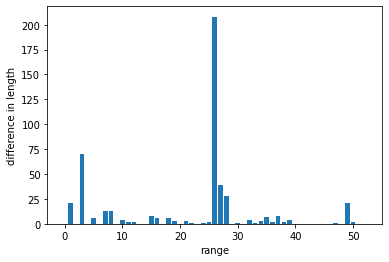

In [68]:
differnt_len_list = []
number = range(53)
for i in number:
    differnt_len = len(answer_predict_len[i]) - len(answer_len[i])
    differnt_len_list.append(differnt_len)

#절댓값으로 변경
len_list = list(map(abs,differnt_len_list))

fig = plt.figure()
x = range(0, 53)
y = len_list
plt.xlabel('range')
plt.ylabel('difference in length')
plt.bar(x, y)
plt.show()

<BarContainer object of 2 artists>

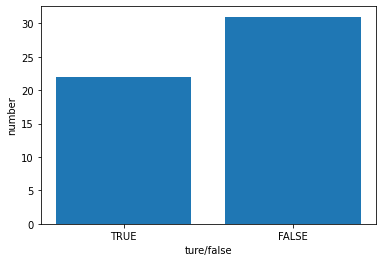

In [67]:
differnt_len_list = []
number = range(53)
for i in number:
    if len(answer_predict_len[i]) == len(answer_len[i]):
        differnt_len_list.append('TRUE')
    else:
        differnt_len_list.append('FALSE')

num_true = differnt_len_list.count('TRUE')
num_false = differnt_len_list.count('FALSE')

######### 시각화 ############
fig = plt.figure()
x = ['TRUE', 'FALSE']
y = num_true, num_false

plt.xlabel('ture/false')
plt.ylabel('number')
plt.bar(x, y)

오... 길이를 비교해보니 차이가 크게 벌어지기도 하고, TRUE의 비율이 Adam을 사용한 것보다 더 떨어진 것을 알 수 있다.   

역시 갓 아담인가...?  싶었는데, 정답 데이터를 뽑아보니 살펴보니 

- 정답 :  45~46cm
- 예측 :  30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm 

이런 식으로 길이 차이는 많이 나지만 정답에 가까운 값을 많이 뽑아낸 것을 알 수 있어 성능은 더 자세히 비교를 해봐야할 것 같다. 

- Adam의 결과  
 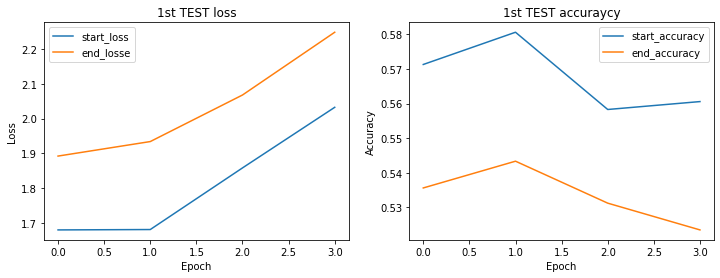

- AdamW의 결과 
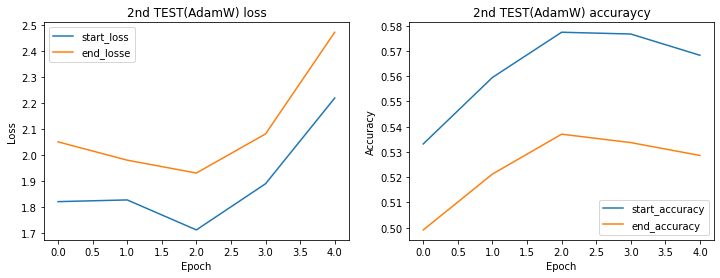

결과 데이터를 비교했을 때, accuracy는 비슷한 loss 값은 Adam이 더 낮은 것으로 확인된다.

## 회고 
---
1. **어려웠던 BERT의 모델 이해하기**  
- 이번 실습을 진행하면서 가장 힘들었던 것은 모델을 이해하는 것이었다. 지난번에 진행한 트랜스포머의 인코더 모형을 그대로 따왔다고 하여 이해하기 쉬울것이라 생각했지만 역시나 쉽지 않았다. 사실 유튜브 영상을 찾아보고, 도서관에서 서적을 찾아 읽으면서 어느정도 BERT의 구동 과정은 이해했으나, 이를 코드로 매치하는 것은 또 다른 문제였다. 그래도 하나하나 따라치고 새로나온 문법들은 블로그로 정리하면서 따라가다보니 어느정도는 머리속에 들어왔다.  
- BERT에서 파생된 RBERT나 ELMO, GPT, PaLM 등 지금 이 순간에도 수많은 모델들이 쏟아져 나오고 있을 것이라 생각된다. 이들을 어떻게 빨리 습득하고 업무에 적용할 것인지 생각해보고 고민해봐야할 것 같다... 이렇게 하는건 시간이 너무 오래걸린다.

2. **알수록 신기한 LNP의 세계**
- 지난 transformer를 진행하면서도 느꼈지만, 자연어, 특히 한국어를 처리하는 것이 참 복잡하지만 재밌는 영역이라는 생각이 든다. 다양한 토큰화 방법(지금은 subword와 더불어 품사를 같이 표현하여 동음어를 더 정확하게 구별하도록 함)이 개발되고 그에따라 사람처럼 혹은 더 확실하게 정답을 뽑아내는 모델이 개발되고 있다고한다. 앞으로는 어떻게 기술이 진보해갈지 궁금하다. 

3. **하이퍼파라미터의 발전**
- BERT를 진행하며 n_head나 d_model 등 다른 파라미터들은 다른 논문이나 다른사람들의 실습내용들과 동일하여 무엇을 변경할까 찾아보던 중 optimizer를 Adam이 아닌 AdamW, AdamWR 등으로 변경한 것을 찾았다.   
- 뭘하든 Adam으로 하면 된다는 말은 이제 점점 옛말이 되어가는 것 같다. 그리고 관련 논문을 보면서 weight decay나 learning rate를 수식을 통해 계산하고 변경하는 것을 보았는데, 이런 논문들을 이해하기 위해 찬찬히 읽으며 학습해야겠다. 
- 그리고 다양하게 쏟아져오는 논문들을 지속적으로 확인해야겠다. 

4. **컴퓨터 구조 학습의 필요성**
- 이번 json 파일, hdf5 파일 등을 사용하면서 화실히 아직 모르는 부분이 많다는 것을 느낀다. 많은 데이터들을 파일화 하여 간단하게 공유하고 사용할 수 있는 방법들을 많이 익혀놔야 현업에서도 잘 적응할 수 있을 것 같은데... 조금씩이라도 시작하자!

5. 이번 실습... 어렵지만 재밌었다...


- [참고 블로그](https://paul-hyun.github.io/bert-02/)